In [1]:
import os
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from PIL import Image, ImageChops
from scipy import ndimage

In [2]:
def load_data(datadir,categories):
    
    datalength = 0
    data = list()
    labels = list()
    for i,category in enumerate(categories):
        path = os.path.join(datadir,category)
        path_list = os.listdir(path)
        if('.DS_Store') in path_list:
            path_list.remove('.DS_Store')
        for img in path_list:
            img_ = os.path.join(path,img)
            img_ = cv2.imread(img_)
            img_ = cv2.cvtColor(img_,cv2.COLOR_BGR2RGB)
            data.append(img_)
            
    return np.asarray(data)

In [3]:
def visualize(images):
    i = 0
    
    rows = 4
    columns = 3
    fig=plt.figure(figsize=(12, 12))
    
    for image in images:
        
        fig.add_subplot(rows,columns,i+1)
        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        plt.title("Image "+str(i+1))
        i+=1

In [14]:
def rotate_image(mat, angle):

    height, width = mat.shape[:2] 
    image_center = (width/2, height/2) 

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)
    val = int(mat[1][0][0])
   
    abs_cos = abs(rotation_mat[0,0]) 
    abs_sin = abs(rotation_mat[0,1])

    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]
    
    rotated_mat = cv2.warpAffine(mat, rotation_mat, (bound_w, bound_h),borderValue=(val,val,val))
    return rotated_mat

In [15]:
def skew_correction(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    thresh = cv2.threshold(gray, 0, 255,
    cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)[-1]
    
    if angle < -45:
        angle = -(90 + angle)

    else:
        angle = -angle
        
    (h, w) = img.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h),
        flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
#     References: https://www.pyimagesearch.com/2017/02/20/text-skew-correction-opencv-python/
    return rotated

In [16]:
def HoughLinesRotate(img):

    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_edges = cv2.Canny(img_gray, 100, 100, apertureSize=3)
    lines = cv2.HoughLinesP(img_edges, 1, math.pi / 180.0, 100, minLineLength=100, maxLineGap=5)

    angles = []
    val = img[0][0][0]

    for [[x1, y1, x2, y2]] in lines:
        angle = math.degrees(math.atan2(y2 - y1, x2 - x1))
        angles.append(angle)

    median_angle = np.median(angles)
    img_rotated = ndimage.rotate(img, median_angle,mode='constant',cval=val)

    return img_rotated

In [17]:
def trim(im):
    bg = Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = ImageChops.difference(im, bg)
    diff = ImageChops.add(diff, diff, 2.0, -100)
    
    bbox = diff.getbbox()
    
    if bbox:
        x = bbox[0]-50 #left
        y = bbox[1]-50 #top
        v = bbox[2]+50 #right
        z = bbox[3]+50 #bottom
        to_crop = tuple((x,y,v,z))
        return im.crop(to_crop)

## Original Dataset

In [26]:
data = load_data('Renamed',['0','1','2','3','4','5','6','7','8','9'])
data_to_add_noises = data[::50]

In [19]:
visualize(data_to_add_noises)

NameError: name 'visualize' is not defined

## Skew dataset

In [27]:
data_skew = list()
for i in range(len(data_to_add_noises)):
    data_skew.append(rotate_image(data_to_add_noises[i],15))

In [ ]:
visualize(data_skew)

## Corrected dataset

In [168]:
data_corrected = list()
for i in range(len(data_skew)):
    data_corrected.append(skew_correction(data_skew[i]))

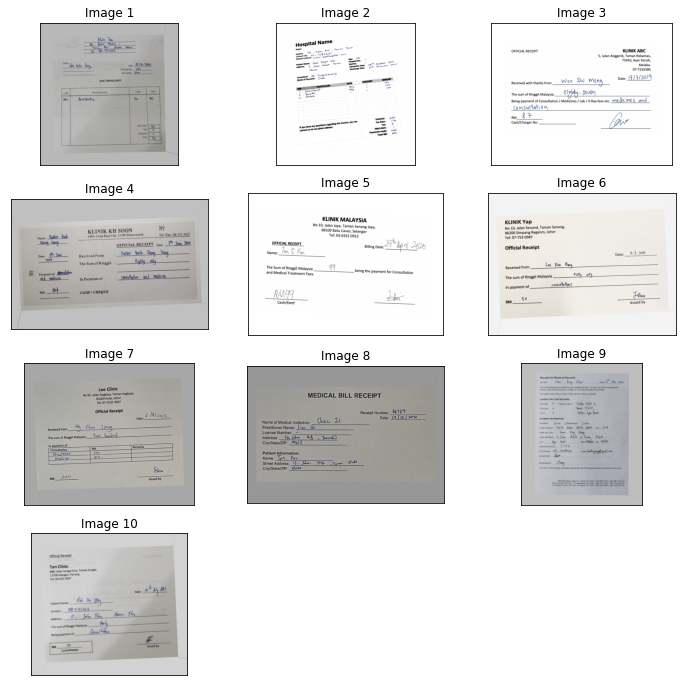

In [169]:
visualize(data_corrected)

## Hough Line Transform

In [28]:
data_corrected2 = list()
for i in range(len(data_skew)):
    data_corrected2.append(HoughLinesRotate(data_skew[i]))

In [22]:
visualize(data_corrected2)

NameError: name 'visualize' is not defined

## Despeckle

In [15]:
img = data_corrected2[0]

In [48]:
despeckle_img = cv2.fastNlMeansDenoising(img,30,7,21)

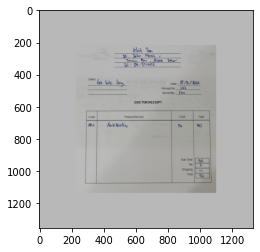

In [49]:
plt.imshow(img)

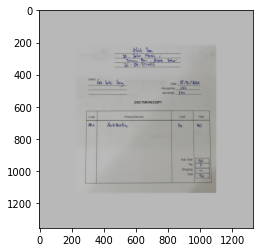

In [50]:
plt.imshow(despeckle_img,'gray')

## Line Removal

In [29]:
def normalize(img):
    rgb_planes = cv2.split(img)

    result_planes = []
    result_norm_planes = []
    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 21)
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        result_planes.append(diff_img)
        result_norm_planes.append(norm_img)

    result = cv2.merge(result_planes)
    result_norm = cv2.merge(result_norm_planes)
    return result_norm

In [37]:
def line_removal(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1]
    baseline = np.zeros(gray.shape,dtype="uint8")
    
    horizontal_line = cv2.getStructuringElement(cv2.MORPH_RECT,(40,1))
    remove_horizontal = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,horizontal_line,iterations=2)
    cnts = cv2.findContours(remove_horizontal, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv2.drawContours(baseline, [c], -1, (255,255,255), 3)
    
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,40))
    remove_vertical = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, vertical_kernel, iterations=2)
    cnts = cv2.findContours(remove_vertical, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv2.drawContours(baseline, [c], -1, (255,255,255), 3)

    dst = cv2.inpaint(gray,baseline,2,cv2.INPAINT_TELEA)
    
    return dst, baseline

In [31]:
img = normalize(data_corrected2[3])

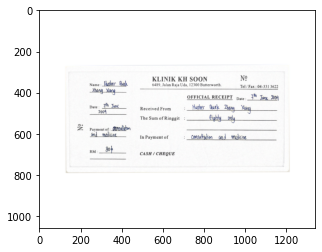

In [32]:
plt.imshow(img)

In [38]:
dst, baseline= line_removal(img)

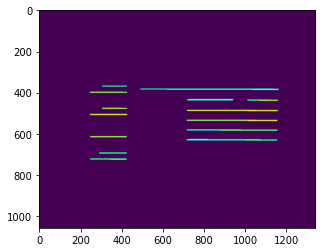

In [39]:
plt.imshow(baseline)

In [34]:
ans = trim(Image.fromarray(dst))

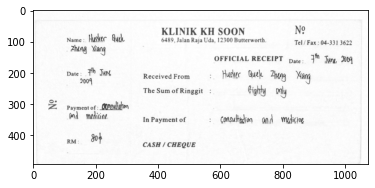

In [35]:
plt.imshow(ans,cmap='gray')

In [453]:
cv2.imwrite('test6.jpg',np.asarray(ans))

True

## Trim

In [320]:
data_trim = list()
for i in range(len(data_corrected2)):
    data_trim.append(trim(Image.fromarray(data_corrected2[i])))

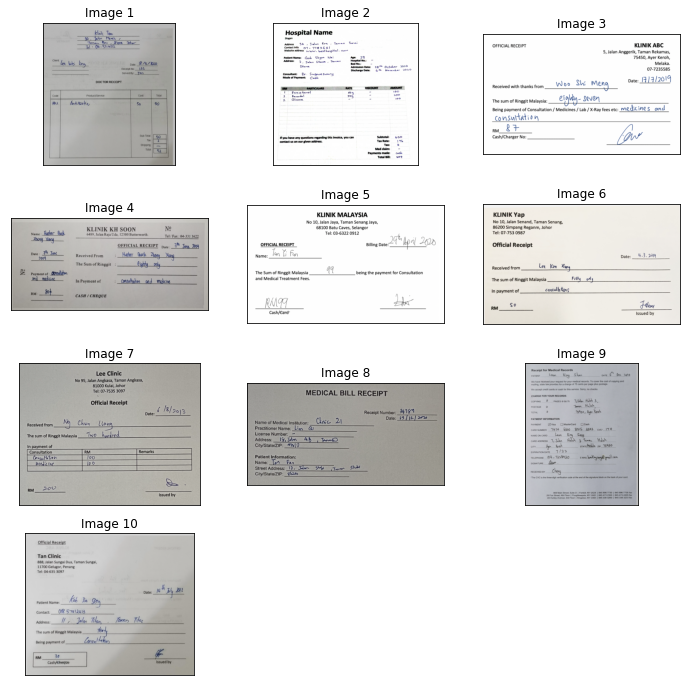

In [321]:
visualize(data_trim)